# 第 11 章 语音助手意图分类

## 11.1 数据集

### 11.1.1 加载数据集

In [145]:
import json
import jieba
import pandas as pd
from typing import List
import matplotlib.pyplot as plt

%matplotlib inline  

plt.rcParams['figure.dpi'] = 180
plt.rcParams['axes.grid'] = False

def read_data_as_pd(file_path: str) -> pd.DataFrame:
    """读取数据集为 DataFrame 格式

    Args:
        file_path: 原文件路径
    Returns:
        数据集 DataFrame
    """
    json_data = json.load(open(file_path,'r', encoding='utf-8'))
    value_list = list(json_data.values())
    return pd.DataFrame(value_list)

train_df = read_data_as_pd('data/SMP2018-Task-1/train.json')
test_df = read_data_as_pd('data/SMP2018-Task-1/dev.json')

<AxesSubplot:xlabel='label'>

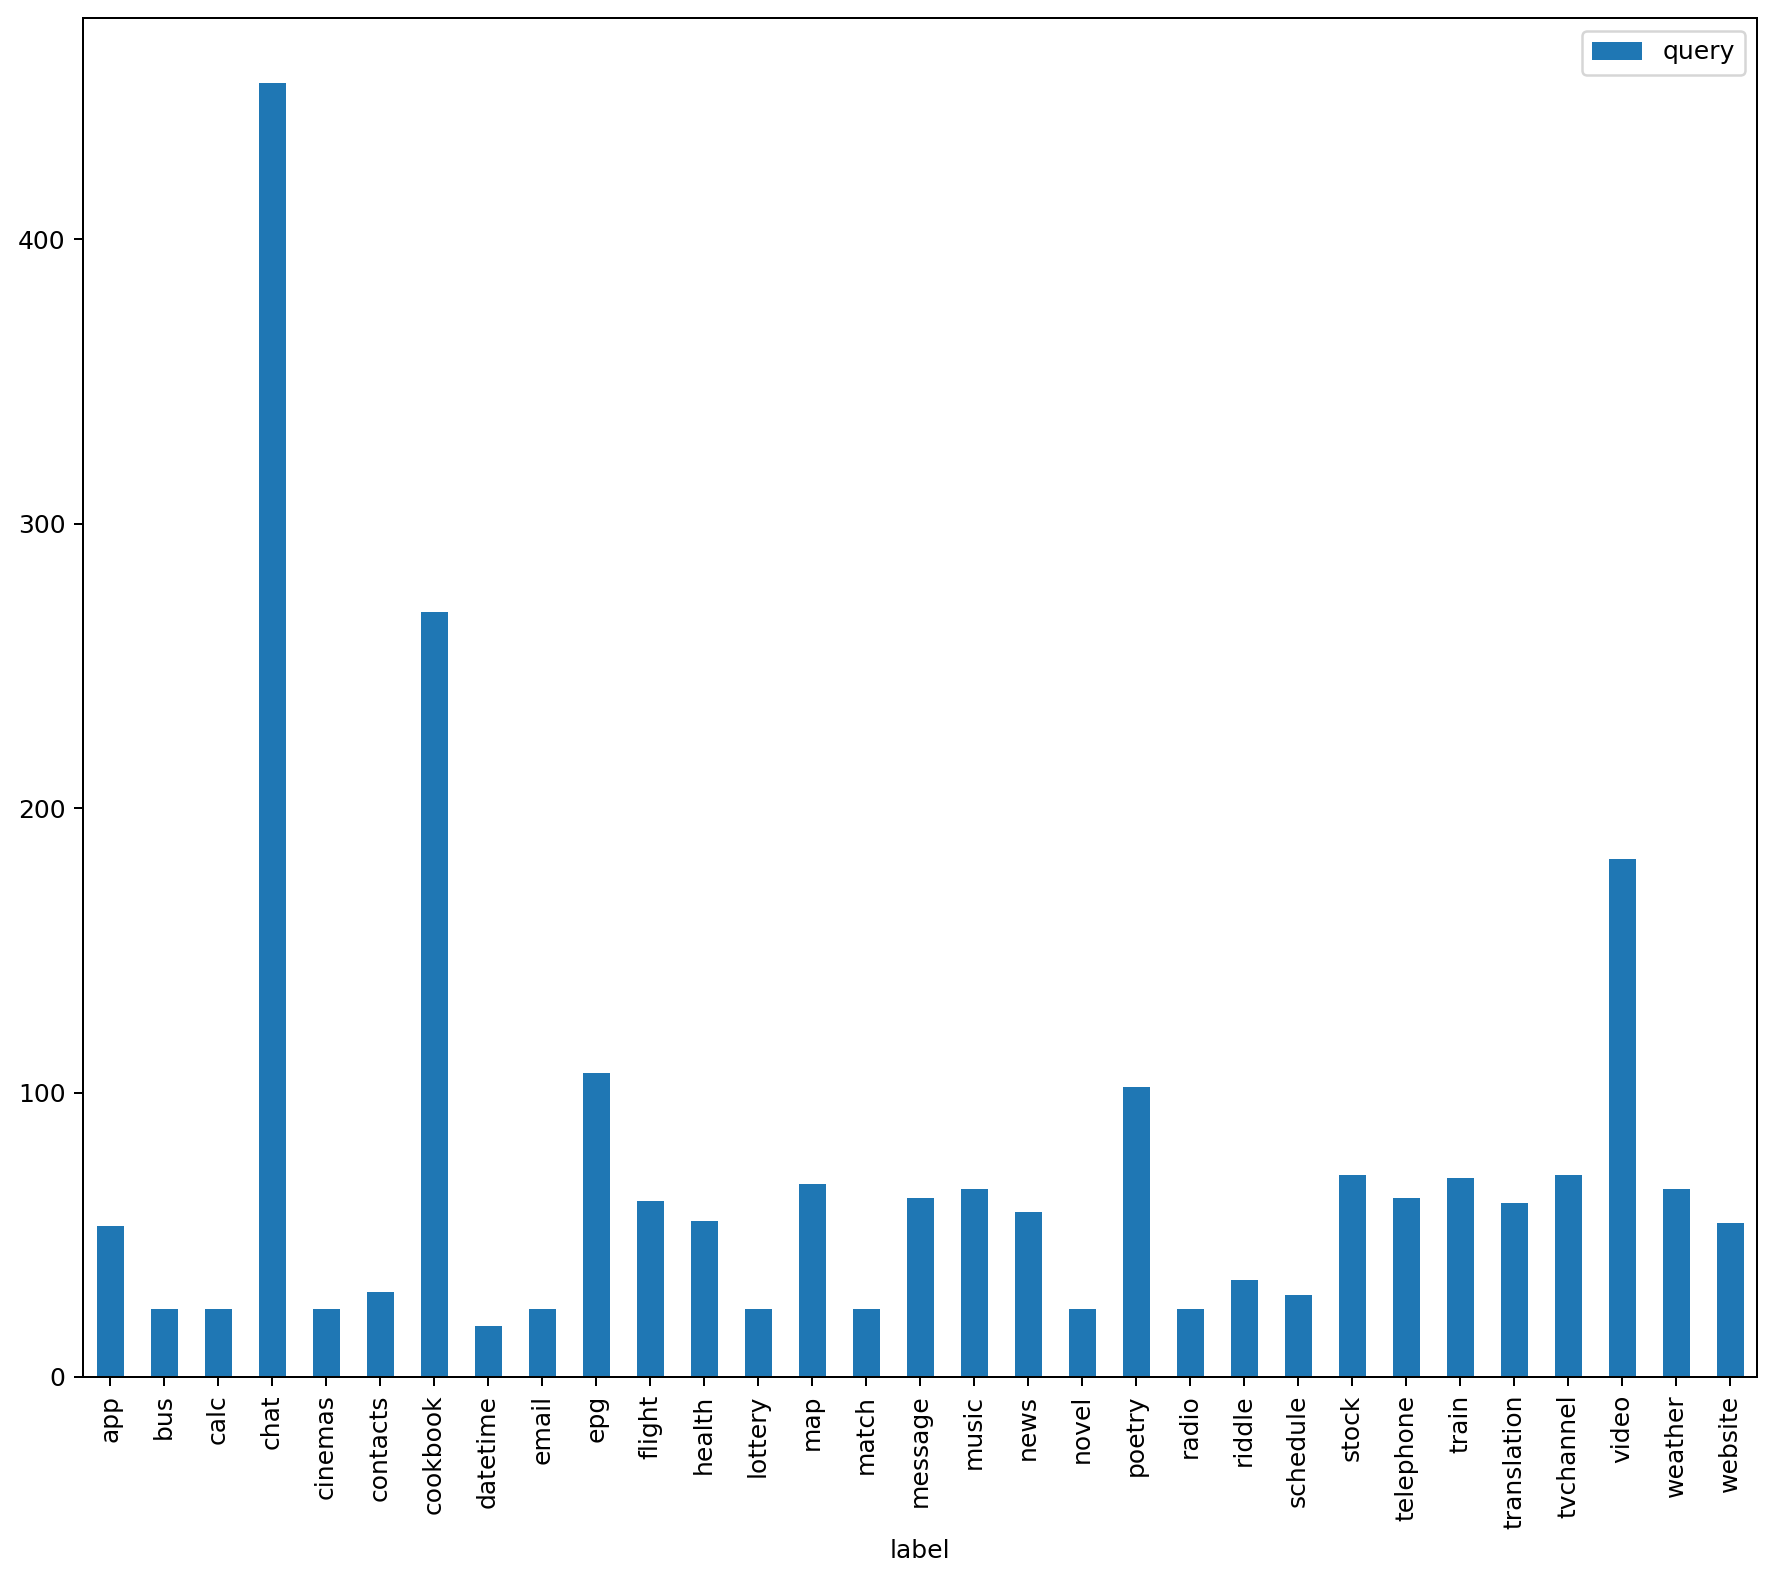

In [146]:
train_df.groupby('label').count().plot.bar(figsize = (12, 10))

### 11.1.2 数据预处理

In [147]:
def process_query(query: str) -> List[str]:
    """ 预处理 query，比如：‘我要看电影 ’ -> ['我要', '看', '电影']

    Args:
        query: query 文本
    Returns:
        处理后的标记数组
    """
    stripped_query = query.strip()
    return list(jieba.cut(stripped_query))

train_df['cutted'] = train_df['query'].apply(process_query)
test_df['cutted'] = test_df['query'].apply(process_query)

train_df.head()

,query,label,cutted
0,今天东莞天气如何,weather,"[今天, 东莞, 天气, 如何]"
1,从观音桥到重庆市图书馆怎么走,map,"[从, 观音桥, 到, 重庆市, 图书馆, 怎么, 走]"
2,鸭蛋怎么腌？,cookbook,"[鸭蛋, 怎么, 腌, ？]"
3,怎么治疗牛皮癣,health,"[怎么, 治疗, 牛皮癣]"
4,唠什么,chat,"[唠, 什么]"


<AxesSubplot:>

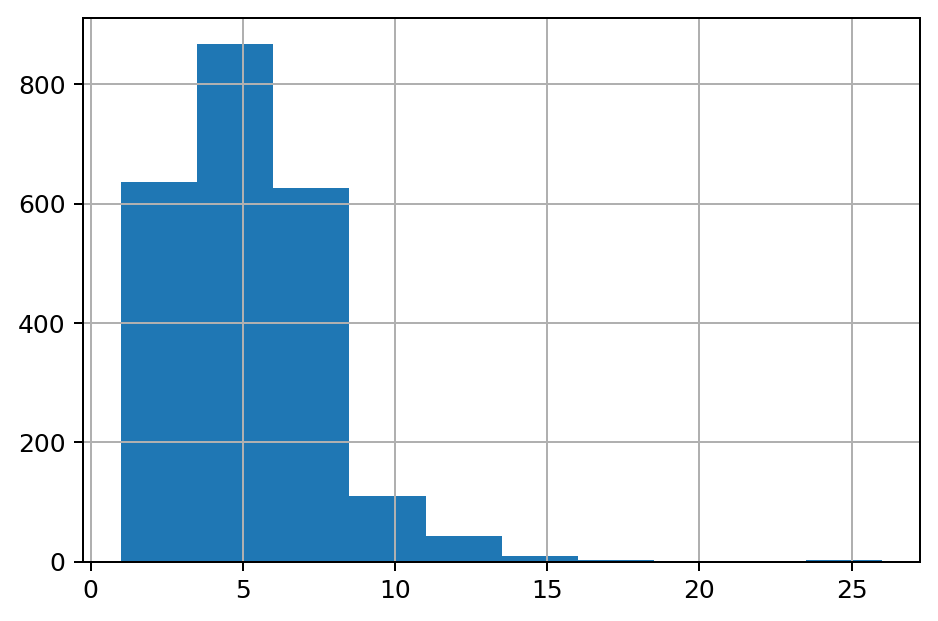

In [148]:
train_df['cutted'].apply(lambda x: len(x)).hist()

In [149]:
import collections
import operator
from typing import List

import os
import json
import gensim
import numpy as np
import pathlib
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences


class Processor(object):

    def __init__(self):
        self.token2idx = {}                          # token 索引字典
        self.token2count = collections.OrderedDict() # token 词频表
        self.label2idx = {}                          # 标签索引词典
        self.idx2label = {}                          # 索引索引字典

    def build_token_dict(self, corpus: List[List[str]]):
        """
        构建 token 字典，这个方法将会遍历分词后的语料，构建一个标记频率字典和标记与索引的映射字典
        Args:
            corpus: 所有分词后的语料
        """
        token2idx = {
            '<PAD>': 0,
            '<UNK>': 1
        }

        token2count = {}
        for sentence in corpus:
            for token in sentence:
                count = token2count.get(token, 0)
                token2count[token] = count + 1
        # 按照词频降序排序
        sorted_token2count = sorted(token2count.items(),
                                    key=operator.itemgetter(1),
                                    reverse=True)
        self.token2count = collections.OrderedDict(sorted_token2count)

        for token in self.token2count.keys():
            token2idx[token] = len(token2idx)
        self.token2idx = token2idx

    def build_label_dict(self, labels: List[str]):
        """
        构建标签索引映射字典
        Args:
            labels: 所有语料对应的标记
        """
        label2idx = {}
        for label in labels:
            if label not in label2idx:
                label2idx[label] = len(label2idx)
        self.label2idx = label2idx
        self.idx2label = dict([(index, label) for label, index in label2idx.items()])

    def convert_text_to_index(self, sentence: List[str]):
        """
        将分词后的标记（token）数组转换成对应的索引数组
        如 ['我', '想', '睡觉'] -> [10, 313, 233]
        Args:
            sentence: 分词后的标记数组
        Returns: 输入数据对应的索引数组
        """
        token_result = []
        for token in sentence:
            token_result.append(self.token2idx.get(token, self.token2idx['<UNK>']))
        return token_result

In [150]:
processor = Processor()
processor.build_token_dict(list(train_df.cutted) + list(test_df.cutted))
processor.build_label_dict(list(train_df.label) + list(test_df.label))

In [151]:
query_idx = processor.convert_text_to_index(['今天', '东莞', '天气', '如何'])
print(query_idx)

[30, 410, 27, 101]


In [152]:
# 分词后的 query 转换为对应的索引数组
train_x = [processor.convert_text_to_index(query) for query in list(train_df.cutted)]
test_x  = [processor.convert_text_to_index(query) for query in list(test_df.cutted)]

# 补全序列到统一长度
train_x = pad_sequences(train_x, maxlen=15)
test_x  = pad_sequences(test_x, maxlen=15)

# 标签转换为对应的索引
train_y = np.array([processor.label2idx[label] for label in list(train_df.label)])
test_y  = np.array([processor.label2idx[label] for label in list(test_df.label)])

print(train_x[:5])
print(train_y[:5])

[[   0    0    0    0    0    0    0    0    0    0    0   30  410   27
   101]
 [   0    0    0    0    0    0    0    0   49 1159    9 1160 1161    6
    59]
 [   0    0    0    0    0    0    0    0    0    0    0 1162    6 1163
     7]
 [   0    0    0    0    0    0    0    0    0    0    0    0    6  138
  1164]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0  711
     8]]
[0 1 2 3 4]


## 11.2 双向 LSTM 网络

In [153]:
L = tf.keras.layers

model = tf.keras.Sequential([
    # 使用 Embedding 层做词嵌入，输入维度等于词表词数量
    L.Embedding(input_dim=len(processor.token2idx),
                output_dim=100,
                input_shape=(15,)),
    # 双向 LSTM
    L.Bidirectional(L.LSTM(64)),
    # 全连接层
    L.Dense(64, activation=tf.nn.relu),
    # 最后一个全连接层输出维度等于标签数量
    L.Dense(len(processor.label2idx), activation=tf.nn.softmax)
    ])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

hist = model.fit(train_x,
                 train_y,
                 validation_split=0.15,
                 epochs=20)

test_loss, test_acc = model.evaluate(test_x, test_y, verbose=0)
print(f'test loss: {test_loss}, test accuracy: {test_acc}')

NotImplementedError: Cannot convert a symbolic Tensor (bidirectional_16/forward_lstm_16/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
def visualize_train_process(history: tf.keras.callbacks.History,
                            title: str):
    plt.figure()
    # 设定子图大小
    plt.subplots(figsize=(10,4))
    for index, target in enumerate(['accuracy', 'loss']):
        plt.subplot(1, 2, index + 1)
        plt.plot(history.history[target], label=target)
        plt.plot(history.history[f'val_{target}'], label=f'val_{target}')
        plt.legend()
        plt.title(f'{title} {target}')
    plt.show()

In [ ]:
visualize_train_process(hist, 'BiLSTM')

## 11.3 预训练词嵌入网络

In [ ]:
class Processor(object):

    def __init__(self):
        self.token2idx = {}                          # token 索引字典
        self.token2count = collections.OrderedDict() # token 词频表
        self.label2idx = {}                          # 标签索引词典
        self.idx2label = {}                          # 索引索引字典

    def build_token_dict(self, corpus: List[List[str]]):
        """
        构建 token 字典，这个方法将会遍历分词后的语料，构建一个标记频率字典和标记与索引的映射字典
        Args:
            corpus: 所有分词后的语料
        """
        token2idx = {
            '<PAD>': 0,
            '<UNK>': 1
        }

        token2count = {}
        for sentence in corpus:
            for token in sentence:
                count = token2count.get(token, 0)
                token2count[token] = count + 1
        # 按照词频降序排序
        sorted_token2count = sorted(token2count.items(),
                                    key=operator.itemgetter(1),
                                    reverse=True)
        self.token2count = collections.OrderedDict(sorted_token2count)

        for token in self.token2count.keys():
            token2idx[token] = len(token2idx)
        self.token2idx = token2idx

    def build_label_dict(self, labels: List[str]):
        """
        构建标签索引映射字典
        Args:
            labels: 所有语料对应的标记
        """
        label2idx = {}
        for label in labels:
            if label not in label2idx:
                label2idx[label] = len(label2idx)
        self.label2idx = label2idx
        self.idx2label = dict([(index, label) for label, index in label2idx.items()])

    def convert_text_to_index(self, sentence: List[str]):
        """
        将分词后的标记（token）数组转换成对应的索引数组
        如 ['我', '想', '睡觉'] -> [10, 313, 233]
        Args:
            sentence: 分词后的标记数组
        Returns: 输入数据对应的索引数组
        """
        token_result = []
        for token in sentence:
            token_result.append(self.token2idx.get(token, self.token2idx['<UNK>']))
        return token_result
    
    def build_from_w2v(self, w2v_path: str):
        """
        使用预训练词嵌入构建词表和词向量表
        Args:
            w2v_path: 预训练词嵌入文件路径
        """
        w2v = gensim.models.KeyedVectors.load_word2vec_format(w2v_path)

        token2idx = {
            '<PAD>': 0, # 由于我们用 0 补全序列，所以补全标记的索引必须为 0
            '<UNK>': 1  # 新词标记的索引可以使任何一个，设置为 1 只是为了方便
        }

        # 我们遍历预训练词嵌入的词表，加入到我们的标记索引词典
        for token in w2v.index2word:
            token2idx[token] = len(token2idx)

        # 初始化一个形状为 [标记总数，预训练向量维度] 的全 0 张量
        vector_matrix = np.zeros((len(token2idx), w2v.vector_size))
        # 随机初始化 <UNK> 标记的张量
        vector_matrix[1] = np.random.rand(300)
        # 从索引 2 开始使用预训练的向量
        vector_matrix[2:] = w2v.vectors
        self.w2v = w2v
        self.vector_matrix = vector_matrix
        self.token2idx = token2idx

In [ ]:
w2v_processor = Processor()
w2v_processor.build_from_w2v('data/word2vec/sgns.weibo.bigram-char')
w2v_processor.build_label_dict(list(train_df.label) + list(test_df.label))

In [ ]:
# 分词后的 query 转换为对应的索引数组
w2v_train_x = [w2v_processor.convert_text_to_index(query) for query in list(train_df.cutted)]
w2v_test_x  = [w2v_processor.convert_text_to_index(query) for query in list(test_df.cutted)]

# 补全序列到统一长度
w2v_train_x = pad_sequences(w2v_train_x, maxlen=15)
w2v_test_x  = pad_sequences(w2v_test_x, maxlen=15)

# 标签转换为对应的索引
w2v_train_y = np.array([processor.label2idx[label] for label in list(train_df.label)])
w2v_test_y  = np.array([processor.label2idx[label] for label in list(test_df.label)])
 

In [ ]:
w2v_model = tf.keras.Sequential([
    L.Embedding(input_dim=len(w2v_processor.token2idx),
                output_dim=w2v_processor.w2v.vector_size,
                weights=[w2v_processor.vector_matrix],
                input_shape=(15,),
                trainable=False),
    L.Bidirectional(L.LSTM(64)),
    L.Dense(64, activation=tf.nn.relu),
    L.Dense(len(w2v_processor.label2idx), activation=tf.nn.softmax)]
)

w2v_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
w2v_model.summary()

w2v_hist = w2v_model.fit(w2v_train_x,
                         w2v_train_y,
                         validation_split=0.15,
                         epochs=20)
test_loss, test_acc = w2v_model.evaluate(test_x, test_y, verbose=0)
print(f'test loss: {test_loss}, test accuracy: {test_acc}')

In [ ]:
visualize_train_process(w2v_hist, 'BiLSTM')

## 11.4 保存和加载模型

In [ ]:
class Processor(object):

    def __init__(self):
        self.token2idx = {}                          # token 索引字典
        self.token2count = collections.OrderedDict() # token 词频表
        self.label2idx = {}                          # 标签索引词典
        self.idx2label = {}                          # 索引索引字典

    def build_token_dict(self, corpus: List[List[str]]):
        """
        构建 token 字典，这个方法将会遍历分词后的语料，构建一个标记频率字典和标记与索引的映射字典
        Args:
            corpus: 所有分词后的语料
        """
        token2idx = {
            '<PAD>': 0,
            '<UNK>': 1
        }

        token2count = {}
        for sentence in corpus:
            for token in sentence:
                count = token2count.get(token, 0)
                token2count[token] = count + 1
        # 按照词频降序排序
        sorted_token2count = sorted(token2count.items(),
                                    key=operator.itemgetter(1),
                                    reverse=True)
        self.token2count = collections.OrderedDict(sorted_token2count)

        for token in self.token2count.keys():
            token2idx[token] = len(token2idx)
        self.token2idx = token2idx

    def build_label_dict(self, labels: List[str]):
        """
        构建标签索引映射字典
        Args:
            labels: 所有语料对应的标记
        """
        label2idx = {}
        for label in labels:
            if label not in label2idx:
                label2idx[label] = len(label2idx)
        self.label2idx = label2idx
        self.idx2label = dict([(index, label) for label, index in label2idx.items()])

    def convert_text_to_index(self, sentence: List[str]):
        """
        将分词后的标记（token）数组转换成对应的索引数组
        如 ['我', '想', '睡觉'] -> [10, 313, 233]
        Args:
            sentence: 分词后的标记数组
        Returns: 输入数据对应的索引数组
        """
        token_result = []
        for token in sentence:
            token_result.append(self.token2idx.get(token, self.token2idx['<UNK>']))
        return token_result
    
    def build_from_w2v(self, w2v_path: str):
        """
        使用预训练词嵌入构建词表和词向量表
        Args:
            w2v_path: 预训练词嵌入文件路径
        """
        w2v = gensim.models.KeyedVectors.load_word2vec_format(w2v_path)

        token2idx = {
            '<PAD>': 0, # 由于我们用 0 补全序列，所以补全标记的索引必须为 0
            '<UNK>': 1  # 新词标记的索引可以使任何一个，设置为 1 只是为了方便
        }

        # 我们遍历预训练词嵌入的词表，加入到我们的标记索引词典
        for token in w2v.index2word:
            token2idx[token] = len(token2idx)

        # 初始化一个形状为 [标记总数，预训练向量维度] 的全 0 张量
        vector_matrix = np.zeros((len(token2idx), w2v.vector_size))
        # 随机初始化 <UNK> 标记的张量
        vector_matrix[1] = np.random.rand(300)
        # 从索引 2 开始使用预训练的向量
        vector_matrix[2:] = w2v.vectors
        self.w2v = w2v
        self.vector_matrix = vector_matrix
        self.token2idx = token2idx
        
    def save_processor(self, folder: str):
        """
        保存 Processor 信息到目标文件夹
        Args:
            folder: 目标文件夹路径
        """
        pathlib.Path(folder).mkdir(exist_ok=True, parents=True)
        token_index_path = os.path.join(folder, 'token_index.json')
        with open(token_index_path, 'w') as f:
            f.write(json.dumps(self.token2idx, ensure_ascii=False, indent=2))

        label_index_path = os.path.join(folder, 'label_index.json')
        with open(label_index_path, 'w') as f:
            f.write(json.dumps(self.label2idx, ensure_ascii=False, indent=2))

    def load_processor(self, folder: str):
        """
        加载保存的 Processor
        Args:
            folder: 目标文件夹路径
        """
        token_index_path = os.path.join(folder, 'token_index.json')
        with open(token_index_path, 'r') as f:
            self.token2idx = json.load(f)

        label_index_path = os.path.join(folder, 'label_index.json')
        with open(label_index_path, 'r') as f:
            self.label2idx = json.load(f)
            self.idx2label = dict([(v, k) for k, v in self.label2idx.items()])

In [ ]:
# 由于给该类增加了方法，需要重新初始化 Processor 构建词表
new_w2v_processor = Processor()
new_w2v_processor.build_from_w2v('data/word2vec/sgns.weibo.bigram-char')
new_w2v_processor.build_label_dict(list(train_df.label) + list(test_df.label))

In [ ]:
# 保存 Processor
new_w2v_processor.save_processor('outputs/chapter-10/processor')
# 保存模型
w2v_model.save('outputs/chapter10/w2v_model.h5')

In [ ]:
# 加载 Processor
loaded_processor = Processor()
loaded_processor.load_processor('outputs/chapter-10/processor')

# 加载模型
loaded_model = tf.keras.models.load_model('outputs/chapter10/w2v_model.h5')
loaded_model.summary()

# 预测新 query
text = '我想看生活大爆炸'
# 先进行分词并转换成其索引
processed = process_query(text)
idx = loaded_processor.convert_text_to_index(processed)
print(f'text to idx: {text} -> {idx}')

# 补全序列长度
padding_idx = pad_sequences([idx], 15)
print(f'padding inputs: {padding_idx}')

# 使用模型预测并且把标签索引转换为对应的标签
label_idx = loaded_model.predict(padding_idx).argmax(-1)[0]
print(f'result domain: {loaded_processor.idx2label[label_idx]}')

In [ ]:
w2v_processor = Processor()
w2v_processor.build_from_w2v('data/word2vec/sgns.weibo.bigram-char')
w2v_processor.build_label_dict(list(train_df.label) + list(test_df.label))

In [ ]:
# 分词后的 query 转换为对应的索引数组
w2v_train_x = [w2v_processor.convert_text_to_index(query) for query in list(train_df.cutted)]
w2v_test_x  = [w2v_processor.convert_text_to_index(query) for query in list(test_df.cutted)]

# 补全序列到统一长度
w2v_train_x = pad_sequences(w2v_train_x, maxlen=15)
w2v_test_x  = pad_sequences(w2v_test_x, maxlen=15)

# 标签转换为对应的索引
w2v_train_y = np.array([processor.label2idx[label] for label in list(train_df.label)])
w2v_test_y  = np.array([processor.label2idx[label] for label in list(test_df.label)])
 

In [ ]:
w2v_model = tf.keras.Sequential([
    L.Embedding(input_dim=len(w2v_processor.token2idx),
                output_dim=w2v_processor.w2v.vector_size,
                weights=[w2v_processor.vector_matrix],
                input_shape=(15,),
                trainable=False),
    L.Bidirectional(L.LSTM(64)),
    L.Dense(64, activation=tf.nn.relu),
    L.Dense(len(w2v_processor.label2idx), activation=tf.nn.softmax)]
)

w2v_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
w2v_model.summary()

w2v_hist = w2v_model.fit(w2v_train_x,
                         w2v_train_y,
                         validation_split=0.15,
                         epochs=20)
test_loss, test_acc = w2v_model.evaluate(test_x, test_y, verbose=0)
print(f'test loss: {test_loss}, test accuracy: {test_acc}')

In [ ]:
visualize_train_process(w2v_hist, 'BiLSTM')

## 11.4 保存和加载模型

In [ ]:
class Processor(object):

    def __init__(self):
        self.token2idx = {}                          # token 索引字典
        self.token2count = collections.OrderedDict() # token 词频表
        self.label2idx = {}                          # 标签索引词典
        self.idx2label = {}                          # 索引索引字典

    def build_token_dict(self, corpus: List[List[str]]):
        """
        构建 token 字典，这个方法将会遍历分词后的语料，构建一个标记频率字典和标记与索引的映射字典
        Args:
            corpus: 所有分词后的语料
        """
        token2idx = {
            '<PAD>': 0,
            '<UNK>': 1
        }

        token2count = {}
        for sentence in corpus:
            for token in sentence:
                count = token2count.get(token, 0)
                token2count[token] = count + 1
        # 按照词频降序排序
        sorted_token2count = sorted(token2count.items(),
                                    key=operator.itemgetter(1),
                                    reverse=True)
        self.token2count = collections.OrderedDict(sorted_token2count)

        for token in self.token2count.keys():
            token2idx[token] = len(token2idx)
        self.token2idx = token2idx

    def build_label_dict(self, labels: List[str]):
        """
        构建标签索引映射字典
        Args:
            labels: 所有语料对应的标记
        """
        label2idx = {}
        for label in labels:
            if label not in label2idx:
                label2idx[label] = len(label2idx)
        self.label2idx = label2idx
        self.idx2label = dict([(index, label) for label, index in label2idx.items()])

    def convert_text_to_index(self, sentence: List[str]):
        """
        将分词后的标记（token）数组转换成对应的索引数组
        如 ['我', '想', '睡觉'] -> [10, 313, 233]
        Args:
            sentence: 分词后的标记数组
        Returns: 输入数据对应的索引数组
        """
        token_result = []
        for token in sentence:
            token_result.append(self.token2idx.get(token, self.token2idx['<UNK>']))
        return token_result
    
    def build_from_w2v(self, w2v_path: str):
        """
        使用预训练词嵌入构建词表和词向量表
        Args:
            w2v_path: 预训练词嵌入文件路径
        """
        w2v = gensim.models.KeyedVectors.load_word2vec_format(w2v_path)

        token2idx = {
            '<PAD>': 0, # 由于我们用 0 补全序列，所以补全标记的索引必须为 0
            '<UNK>': 1  # 新词标记的索引可以使任何一个，设置为 1 只是为了方便
        }

        # 我们遍历预训练词嵌入的词表，加入到我们的标记索引词典
        for token in w2v.index2word:
            token2idx[token] = len(token2idx)

        # 初始化一个形状为 [标记总数，预训练向量维度] 的全 0 张量
        vector_matrix = np.zeros((len(token2idx), w2v.vector_size))
        # 随机初始化 <UNK> 标记的张量
        vector_matrix[1] = np.random.rand(300)
        # 从索引 2 开始使用预训练的向量
        vector_matrix[2:] = w2v.vectors
        self.w2v = w2v
        self.vector_matrix = vector_matrix
        self.token2idx = token2idx
        
    def save_processor(self, folder: str):
        """
        保存 Processor 信息到目标文件夹
        Args:
            folder: 目标文件夹路径
        """
        pathlib.Path(folder).mkdir(exist_ok=True, parents=True)
        token_index_path = os.path.join(folder, 'token_index.json')
        with open(token_index_path, 'w') as f:
            f.write(json.dumps(self.token2idx, ensure_ascii=False, indent=2))

        label_index_path = os.path.join(folder, 'label_index.json')
        with open(label_index_path, 'w') as f:
            f.write(json.dumps(self.label2idx, ensure_ascii=False, indent=2))

    def load_processor(self, folder: str):
        """
        加载保存的 Processor
        Args:
            folder: 目标文件夹路径
        """
        token_index_path = os.path.join(folder, 'token_index.json')
        with open(token_index_path, 'r') as f:
            self.token2idx = json.load(f)

        label_index_path = os.path.join(folder, 'label_index.json')
        with open(label_index_path, 'r') as f:
            self.label2idx = json.load(f)
            self.idx2label = dict([(v, k) for k, v in self.label2idx.items()])

In [ ]:
# 由于给该类增加了方法，需要重新初始化 Processor 构建词表
new_w2v_processor = Processor()
new_w2v_processor.build_from_w2v('data/word2vec/sgns.weibo.bigram-char')
new_w2v_processor.build_label_dict(list(train_df.label) + list(test_df.label))

In [ ]:
# 保存 Processor
new_w2v_processor.save_processor('outputs/chapter-10/processor')
# 保存模型
w2v_model.save('outputs/chapter10/w2v_model.h5')

In [ ]:
# 加载 Processor
loaded_processor = Processor()
loaded_processor.load_processor('outputs/chapter-10/processor')

# 加载模型
loaded_model = tf.keras.models.load_model('outputs/chapter10/w2v_model.h5')
loaded_model.summary()

# 预测新 query
text = '我想看生活大爆炸'
# 先进行分词并转换成其索引
processed = process_query(text)
idx = loaded_processor.convert_text_to_index(processed)
print(f'text to idx: {text} -> {idx}')

# 补全序列长度
padding_idx = pad_sequences([idx], 15)
print(f'padding inputs: {padding_idx}')

# 使用模型预测并且把标签索引转换为对应的标签
label_idx = loaded_model.predict(padding_idx).argmax(-1)[0]
print(f'result domain: {loaded_processor.idx2label[label_idx]}')

In [ ]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))